# DDM

- this script visualizes DDM results with fit parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import os
from scipy.optimize import minimize
import glob
import matplotlib.ticker as mticker


sns.set(style='white')
sns.set_context("poster")

/Users/isaacchristian/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# load participant data

- The DDM will simulate all trials that participants experienced

In [7]:
# Get data file names
cur_path = os.getcwd()
filenames = glob.glob(cur_path + "/data/*.csv")
# Read dframes into a list
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))
    
    
filt_dfs = []
x = []
# concat all dframes into one dframe
for d in dfs:
    my_df = d.filter(items=['congruent', 'Rand Tim', 'key_resp.rt','block_num'])
    # drop na, only 10s
    filt_dfs.append(my_df.dropna())
    x.append(len(my_df.dropna(subset = ['congruent'])) - len(my_df.dropna(subset = ['key_resp.rt'])))

## concat #
full_dat = pd.concat(filt_dfs)
#x_dat = pd.concat(x)

ValueError: No objects to concatenate

In [4]:
full_dat

,congruent,Rand Tim,key_resp.rt,block_num
1,0.0,1.3132,0.636110,5s
2,1.0,0.7037,0.709031,5s
3,0.0,0.8309,0.434464,5s
4,1.0,4.6764,0.553009,5s
5,0.0,4.6441,0.518856,5s
...,...,...,...,...
416,1.0,4.1302,0.473883,5s
419,0.0,4.1825,0.864461,5s
420,0.0,3.5785,0.386026,5s
421,0.0,1.9596,0.395578,5s


In [4]:
# Restructure full_dat to match df
# Rename columns
full_dat.rename(columns={
    'key_resp.rt': 'rt',
    'Rand Tim': 'onset'
}, inplace=True)

# Map 'congruent' to 'trial_type'
full_dat['trial_type'] = full_dat['congruent'].map({0.0: 'invalid', 1.0: 'valid'})

# Convert 'block_num' to 'task'
# Assuming '5s' corresponds to 5, and you want to convert it to an integer or another value
full_dat['task'] = full_dat['block_num'].str.replace('s', '').astype(int) 

# Drop or reorder columns if necessary
participant_data = full_dat[['rt', 'onset', 'trial_type', 'task']]

# Display the restructured DataFrame
participant_data


,rt,onset,trial_type,task
1,0.636110,1.3132,invalid,5
2,0.709031,0.7037,valid,5
3,0.434464,0.8309,invalid,5
4,0.553009,4.6764,valid,5
5,0.518856,4.6441,invalid,5
...,...,...,...,...
416,0.473883,4.1302,valid,5
419,0.864461,4.1825,invalid,5
420,0.386026,3.5785,invalid,5
421,0.395578,1.9596,invalid,5


# Define functions and vars for the DDM

In [5]:
# Biased coin flip: returns 1 with 80% probability, 0 with 20% probability
def biased_random():
    return np.random.choice([0, 1], p=[0.2, 0.8])

# Binary signal: returns 1 if current time has passed the onset, else 0
def signal(current_time, onset_time):
    return int(current_time >= onset_time)

# Cost function: increasing exponential cost scaled by max value
def cost_function(cost_param, onset_time, max_value=10):
    cost_raw = 0.06 * math.exp(cost_param * onset_time)
    return cost_raw / max_value

# Benefit function: logistic function scaled by time within interval
def benefit_function(prob_param, onset_time, interval_duration):
    normalized_time = onset_time / interval_duration
    return 1 / (1 + math.exp(-prob_param * normalized_time))

# Gain combines benefit and cost
def compute_gain(onset_time, task_duration, prob_param, cost_param, trial_type):
    benefit_val = benefit_function(prob_param, onset_time, task_duration)
    cost_val = cost_function(cost_param, onset_time)
    return benefit_val - cost_val

# Parameters (fit from Drift Diffusion Model)
decision_threshold = 0.4        # Decision threshold
initial_bias = 0.05             # Spatial bias
prob_param = 7.5
cost_param = 0.37
noise_param = 0.0001

# Parameter string identifier
param_id = f'{decision_threshold}_{initial_bias}_{prob_param}_{cost_param}_{noise_param}_1'


### SIMULATE

1s - Valid: 0.385; Invalid: 0.485
3s - Valid: 0.399; Invalid: 0.526
5s - Valid: 0.409; Invalid: 0.519
10s - Valid: 0.431; Invalid: 0.543

Missed trial rate: 0.65%


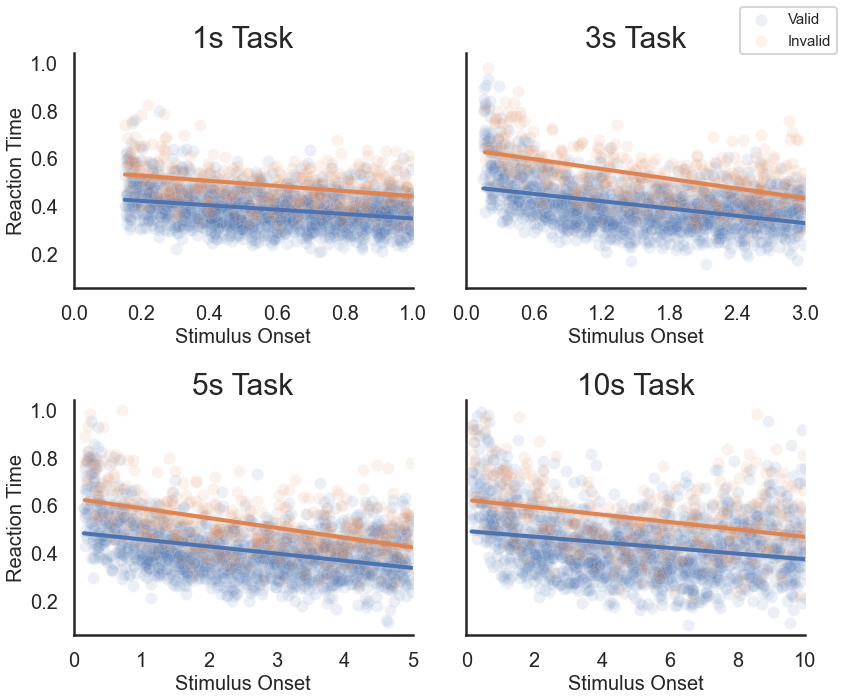

In [6]:
# Seaborn style settings
sns.set(style="white", context="poster")

# Simulation parameters
dt = 0.01                    # Time step
total_trials = 2000         # Number of trials to simulate
task_durations = [1, 3, 5, 10]  # Task intervals (in seconds)
max_task_length = 10        # For normalization
all_dfs = []
missed_trials = 0

# Subplot grid: one for each task condition
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

# Iterate over each task duration
for idx, task_duration in enumerate(task_durations):
    rt_list, onset_list, choice_list, task_list = [], [], [], []

    for _ in range(total_trials):
        evidence = initial_bias
        trial_type = biased_random()
        onset_time = np.random.uniform(0.15, task_duration)
        time = 0.0
        non_decision_time = onset_time

        # Simulate DDM until a boundary is crossed
        while abs(evidence) < decision_threshold:
            stim_on = signal(time, onset_time)

            if stim_on:
                drift = compute_gain(onset_time, task_duration, prob_param, cost_param, trial_type)
                drift *= 1 if trial_type == 1 else -1
                noise = np.random.normal(0, np.sqrt(noise_param))
            else:
                drift = 0
                noise = np.random.normal(0, np.sqrt(0.00001))

            evidence += drift * dt + noise
            time += dt

        # Compute RT (accounting for non-decision time)
        rt = time - non_decision_time
        if rt > 1 or rt < 0:
            missed_trials += 1
            continue

        rt_list.append(rt)
        onset_list.append(onset_time)
        choice_list.append(trial_type)
        task_list.append(task_duration)

    # Create DataFrame for current task
    df = pd.DataFrame({
        'rt': rt_list,
        'onset': onset_list,
        'trial_type': choice_list,
        'task': task_list
    })

    df['trial_type'] = df['trial_type'].map({1: 'valid', 0: 'invalid'})
    all_dfs.append(df)

    print(f"{task_duration}s - Valid: {df[df['trial_type'] == 'valid']['rt'].mean():.3f}; "
          f"Invalid: {df[df['trial_type'] == 'invalid']['rt'].mean():.3f}")

    # Filter long RTs for plotting
    df = df[df['rt'] <= 5]

    row, col = idx // 2, idx % 2

    # Plot valid trials
    sns.scatterplot(data=df[df['trial_type'] == 'valid'], x='onset', y='rt', alpha=0.1, 
                    ax=axes[row, col], label='Valid', legend=False)
    sns.regplot(data=df[df['trial_type'] == 'valid'], x='onset', y='rt', scatter=False, 
                ax=axes[row, col], line_kws={"linewidth": 4})

    # Plot invalid trials
    sns.scatterplot(data=df[df['trial_type'] == 'invalid'], x='onset', y='rt', alpha=0.1, 
                    ax=axes[row, col], label='Invalid', legend=False)
    sns.regplot(data=df[df['trial_type'] == 'invalid'], x='onset', y='rt', scatter=False, 
                ax=axes[row, col], line_kws={"linewidth": 4})

    # Annotate subplots
    axes[row, col].set_title(f'{task_duration}s Task', fontsize=30)
    axes[row, col].set_xlabel('Stimulus Onset', fontsize=20)
    axes[row, col].set_ylabel('Reaction Time', fontsize=20)
    axes[row, col].tick_params(axis='x', labelsize=20)
    axes[row, col].tick_params(axis='y', labelsize=20)
    
    # Set x-ticks evenly spaced
    x_ticks = np.linspace(0, task_duration, 6)
    axes[row, col].set_xticks(x_ticks)

# Combine data across tasks
combined_df = pd.concat(all_dfs, ignore_index=True)
print(f'\nMissed trial rate: {missed_trials / total_trials:.2%}')

# Add global legend
handles, labels = axes[row, col].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=15)

# Final layout tweaks
plt.tight_layout()
sns.despine()
plt.show()


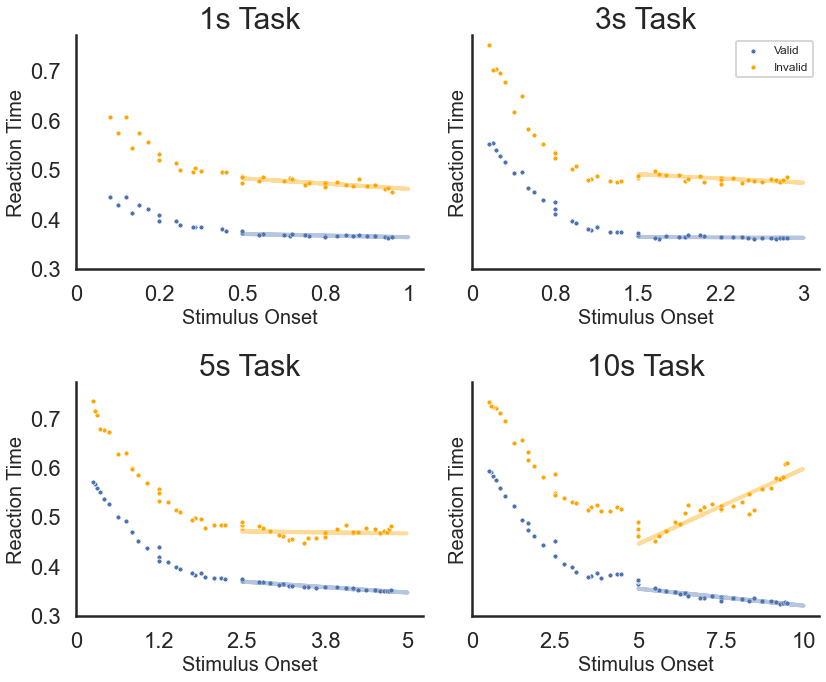

In [9]:

# Define functions if not already defined
def get_binned_rt(dat_con, dat_inc, intervals):
    avs_con = []
    avs_incon = []
    for i in range(1, len(intervals)):
        av_con = dat_con['rt'][(dat_con['onset'] > intervals[i-1]) & (dat_con['onset'] < intervals[i])].mean()
        av_inc = dat_inc['rt'][(dat_inc['onset'] > intervals[i-1]) & (dat_inc['onset'] < intervals[i])].mean()
        avs_con.append(av_con)
        avs_incon.append(av_inc)
    return avs_con, avs_incon

def fit_partial_model(data, cond_len):
    X = np.array(data['onset'][data['onset'] > (cond_len / 2)]).reshape(-1, 1)
    y = data['rt'][data['onset'] > (cond_len / 2)]
    model = LinearRegression()
    model.fit(X, y)
    return X, model.coef_, model.intercept_

def custom_round_ticks(x_ticks):
    return [f"{tick:.1f}".rstrip('0').rstrip('.') for tick in x_ticks]

# Define parameters
target_conditions = [1, 3, 5, 10]
bin_list = np.arange(2, 11, dtype=int)
s1 = 30
s2 = 20

# Create plot structure
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

# Iterate over each condition
for i, cond in enumerate(target_conditions):
    avs_con, avs_incon, x_vals = [], [], []

    # Separate data for 'valid' and 'invalid' trials
    dat_con = big_df[(big_df['trial_type'] == 'valid') & (big_df['task'] == cond)]
    dat_inc = big_df[(big_df['trial_type'] == 'invalid') & (big_df['task'] == cond)]

    # Fit regression models
    c_x_data, c_beta, c_int = fit_partial_model(dat_con, cond)
    i_x_data, i_beta, i_int = fit_partial_model(dat_inc, cond)

    for num_bins in bin_list:
        fac = cond / num_bins
        intervals = np.arange(0, cond + fac, fac)
        xlab = np.arange(fac / 2, cond, fac)
        
        avs_c, avs_inc = get_binned_rt(dat_con, dat_inc, intervals)

        if len(xlab) != len(avs_c):
            continue

        avs_con = np.hstack((avs_con, avs_c))
        avs_incon = np.hstack((avs_incon, avs_inc))
        x_vals = np.hstack((x_vals, xlab))

    # Plot
    row, col = i // 2, i % 2
    sns.scatterplot(x=x_vals, y=avs_con, label='Valid', ax=axes[row, col], color='b', s=25, legend=False)
    sns.scatterplot(x=x_vals, y=avs_incon, label='Invalid', ax=axes[row, col], color='orange', s=25, legend=False)

    # Fit lines
    axes[row, col].plot(c_x_data, c_beta[0] * c_x_data + c_int, color='b', linewidth=4, alpha=.4)
    axes[row, col].plot(i_x_data, i_beta[0] * i_x_data + i_int, color='orange', linewidth=4, alpha=.4)

    # Titles and labels
    axes[row, col].set_title(f'{cond}s Task', fontsize=s1)
    axes[row, col].set_xlabel('Stimulus Onset', fontsize=s2)
    axes[row, col].set_ylabel('Reaction Time', fontsize=s2)

    # Adjust x-ticks
    x_ticks = np.arange(0, cond + cond/4, step=cond / 4)
    axes[row, col].set_xticks(x_ticks)
    axes[row, col].set_xticklabels(custom_round_ticks(x_ticks))

    if i == 1:
        axes[row, col].legend(loc='upper right', fontsize=12)

plt.tight_layout()
sns.despine()
#plt.savefig('sliding_window.png')
plt.show()


### save 

In [265]:
big_df.to_csv(f'FINAL_results_ogcostbenefit_{paramz}.csv')

In [267]:
f'FINAL_results_ogcostbenefit_{paramz}.csv'

'FINAL_results_ogcostbenefit_0.4_0.05_7.5_0.4_0.0001_1.csv'

In [108]:
big_df

,rt,onset,trial_type,task
0,0.034496,0.765504,valid,1
1,0.089069,0.670931,invalid,1
2,0.023378,0.256622,valid,1
3,0.034143,0.955857,invalid,1
4,0.094360,0.735640,invalid,1
...,...,...,...,...
7990,0.050164,6.359836,valid,10
7991,0.156037,3.503963,valid,10
7992,0.128728,4.071272,valid,10
7993,0.426318,4.533682,valid,10
